In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#%pip install missingno
#import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
#from scipy.stats import norm
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import scipy
#import scipy.stats as stats
#from scipy.stats import skew,boxcox_normmax, zscore
#from scipy.special import boxcox1p
#from scipy.stats import boxcox
#from scipy.stats import boxcox_normmax

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [5]:
#######################################################
# For Dataset Loading
######################################################
def load_train():
    data = pd.read_csv("../research/datasets/train.csv")
    return data

def load_test():
    data = pd.read_csv("../research/datasets/test.csv")
    return data

def concat_df_on_y_axis(df_1, df_2):
    return pd.concat([df_1, df_2])

def concat_df_on_x_axis(df_1, df_2):
    return pd.concat([df_1, df_2], axis = 1)

def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


######################################################
# For Outliers
######################################################
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

######################################################
# For Missing Values
######################################################
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return missing_df, na_columns
    
    return missing_df

def quick_missing_imp_groupped(data, cat_cols, num_cols, missing_columns_df, num_method = 'median', groupby = 'Neighborhood', target = 'SalePrice'):
    missing_columns = missing_columns_df.T.columns
    missing_columns = [col for col in missing_columns if col not in target]
    missing_cat_cols = [col for col in missing_columns if col not in num_cols]
    missing_num_cols = [col for col in missing_columns if col not in cat_cols]

    print("# BEFORE")
    print(missing_columns_df)  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    data[missing_cat_cols] = data.groupby(groupby)[missing_cat_cols].transform(lambda x:x.fillna(x.mode()[0]))

    if num_method == "mean":
        data[missing_num_cols] = data.groupby(groupby)[missing_num_cols].transform(lambda x: x.fillna(x.mean()))
        
    elif num_method == "median":
        data[missing_num_cols] = data.groupby(groupby)[missing_num_cols].transform(lambda x: x.fillna(x.median()))
    
    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[missing_columns].isnull().sum(), "\n\n")

    return data


######################################################
# For Encoders
######################################################
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def one_hot_encoder_na_dummy(dataframe, categorical_cols, drop_first=True, dummy_na=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dummy_na = dummy_na)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_analyser(dataframe, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe)}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

######################################################
# For EDA
######################################################
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        #import seaborn as sns
        #import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    #print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

In [6]:
df_train = load_train()
df_test = load_test()
df = concat_df_on_y_axis(df_train, df_test)

C:\Users\BORA\AppData\Local\Temp\ipykernel_20880\785286455.py:5: DtypeWarning: Columns (13,15,19,30,32,37,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../research/datasets/train.csv")


In [7]:
df_copy = df.copy()
check_df(df_copy)

##################### Shape #####################
(76174, 44)
##################### Types #####################
Basvuru Yili                                                   int64
Degerlendirme Puani                                          float64
Cinsiyet                                                      object
Dogum Tarihi                                                  object
Dogum Yeri                                                    object
Ikametgah Sehri                                               object
Universite Adi                                                object
Universite Turu                                               object
Burslu ise Burs Yuzdesi                                      float64
Burs Aliyor mu?                                               object
Bölüm                                                         object
Universite Kacinci Sinif                                      object
Universite Not Ortalamasi                                   

In [9]:
df_copy.drop(['id'], axis = 1, inplace = True)
cat_cols_eda, num_cols_eda, cat_but_car_eda = grab_col_names(df)

Observations: 76174
Variables: 44
cat_cols: 21
num_cols: 4
cat_but_car: 19
num_but_cat: 0


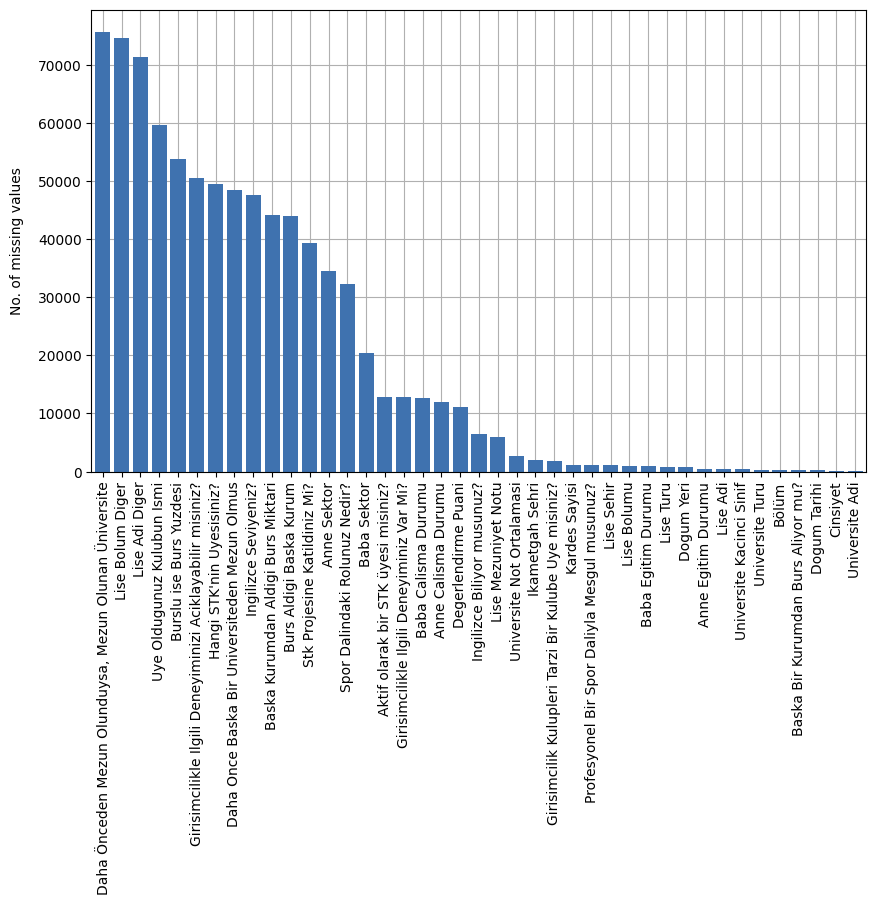

In [10]:
nans = df.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

                       Cinsiyet  Ratio
Cinsiyet                              
Kadın                     32077 49.255
Erkek                     22752 34.936
ERKEK                     10012 15.374
Belirtmek istemiyorum       115  0.177


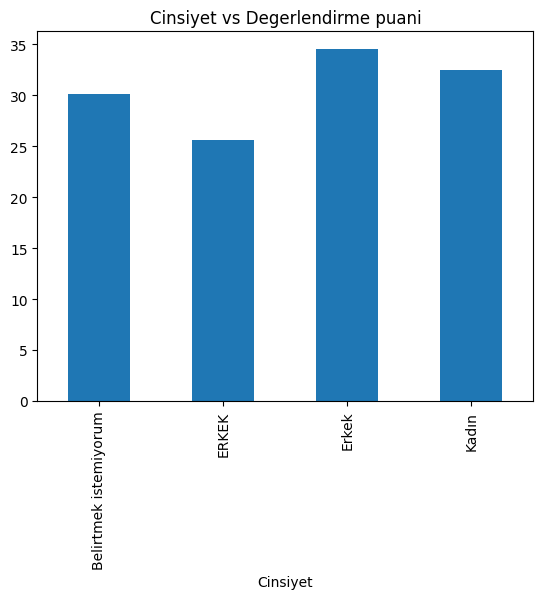

                 Universite Turu  Ratio
Universite Turu                        
Devlet                     37885 58.173
DEVLET                     15377 23.612
Özel                        8336 12.800
ÖZEL                        3272  5.024


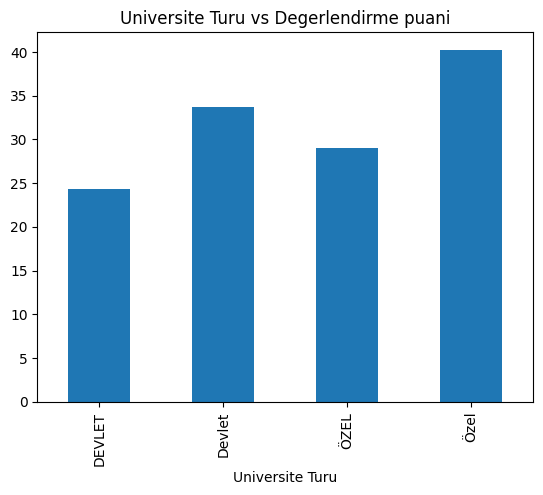

                 Burs Aliyor mu?  Ratio
Burs Aliyor mu?                        
Hayır                      51978 79.813
Evet                        9289 14.263
EVET                        3475  5.336
hayır                        272  0.418
evet                         111  0.170


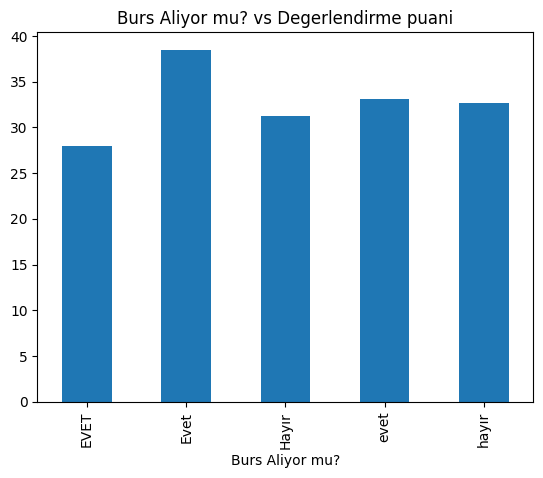

                          Universite Kacinci Sinif  Ratio
Universite Kacinci Sinif                                 
2                                            21773 33.433
3                                            16956 26.036
4                                            13113 20.135
1                                            10260 15.754
Hazırlık                                      1275  1.958
5                                              961  1.476
Mezun                                          178  0.273
6                                              177  0.272
hazırlık                                        33  0.051
Yüksek Lisans                                   15  0.023
Tez                                              7  0.011
0                                                3  0.005


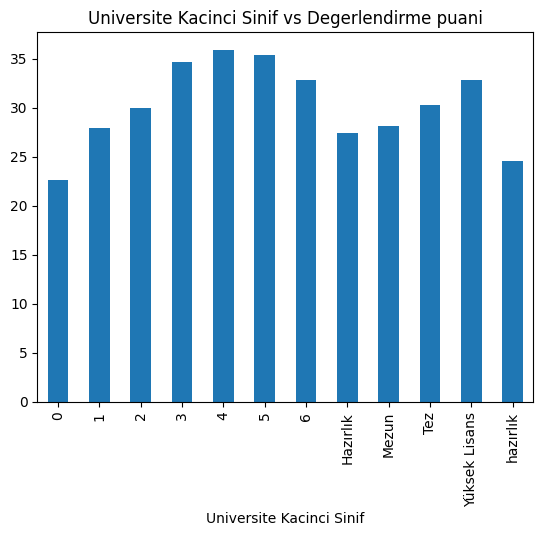

                           Universite Not Ortalamasi  Ratio
Universite Not Ortalamasi                                  
3.00-2.50                                      10758 16.519
2.50 ve altı                                   10554 16.206
3.00 - 3.50                                     7913 12.150
3.50-3                                          6179  9.488
2.50 - 3.00                                     5782  8.878
3.50 - 4.00                                     4462  6.851
2.00 - 2.50                                     2519  3.868
2.50 - 2.99                                     2452  3.765
ORTALAMA BULUNMUYOR                             2399  3.684
3.00 - 3.49                                     2382  3.658
2.50 -3.00                                      1734  2.663
3.00 - 4.00                                     1411  2.167
1.80 - 2.49                                     1166  1.790
Hazırlığım                                       668  1.026
Not ortalaması yok                      

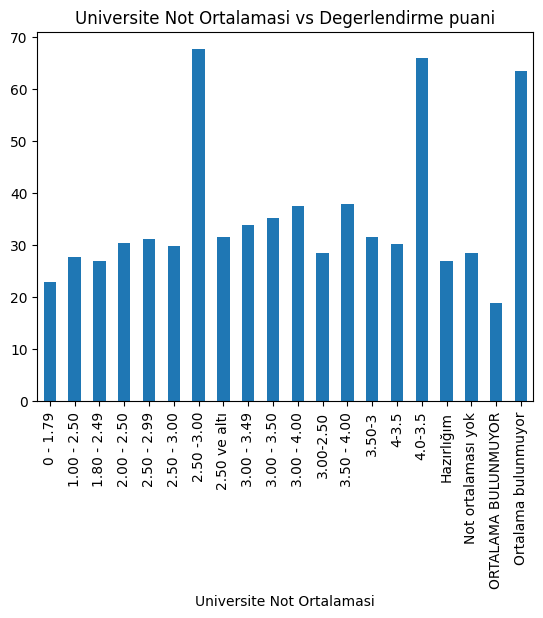

                                               Daha Once Baska Bir Universiteden Mezun Olmus  Ratio
Daha Once Baska Bir Universiteden Mezun Olmus                                                      
Hayır                                                                                  26624 40.881
Evet                                                                                    1156  1.775


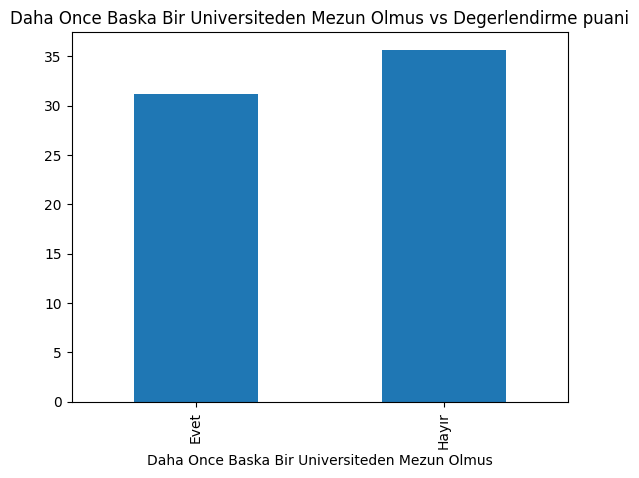

                   Lise Turu  Ratio
Lise Turu                          
Anadolu Lisesi         13367 20.525
Diğer                  13184 20.244
Anadolu lisesi          7002 10.752
Devlet                  6204  9.526
Özel                    4746  7.288
Düz lise                4179  6.417
Meslek lisesi           3666  5.629
Düz Lise                2789  4.283
Meslek                  2454  3.768
Fen Lisesi              2159  3.315
Özel Lisesi             1474  2.263
İmam Hatip Lisesi       1158  1.778
Fen lisesi               660  1.013
Özel lisesi              489  0.751
Meslek Lisesi            415  0.637
Özel Lise                332  0.510


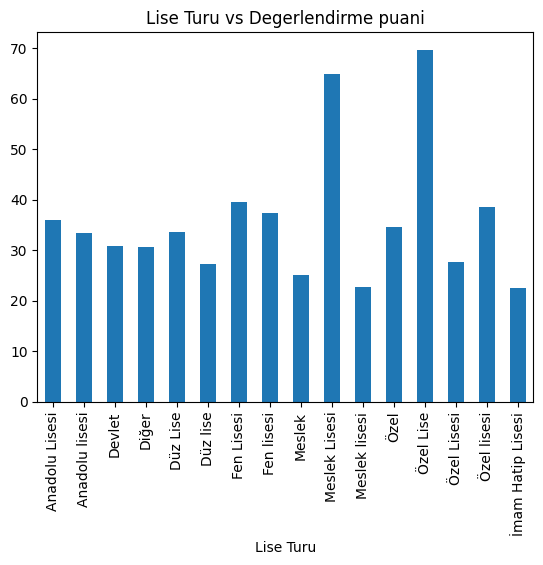

                     Lise Mezuniyet Notu  Ratio
Lise Mezuniyet Notu                            
75 - 100                           22433 34.446
84-70                               9141 14.036
100-85                              6967 10.698
4.00-3.50                           3689  5.664
50 - 75                             3115  4.783
3.00 - 4.00                         3101  4.762
3.50-3.00                           2759  4.236
3.50-3                              2330  3.578
69-55                               2162  3.320
3.00-2.50                           2153  3.306
50 - 74                             1007  1.546
2.50 ve altı                         226  0.347
54-45                                 88  0.135
25 - 50                               14  0.021
Not ortalaması yok                    11  0.017
44-0                                   6  0.009
0 - 25                                 3  0.005
25 - 49                                2  0.003
0 - 24                                 1

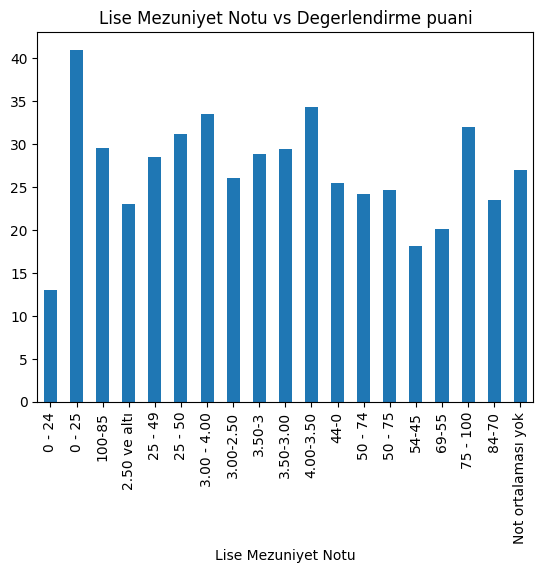

                                    Baska Bir Kurumdan Burs Aliyor mu?  Ratio
Baska Bir Kurumdan Burs Aliyor mu?                                           
Hayır                                                            48513 74.492
Evet                                                             16381 25.153


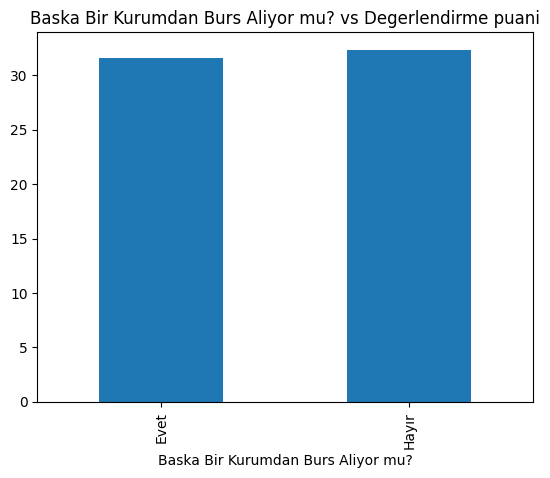

                     Anne Calisma Durumu  Ratio
Anne Calisma Durumu                            
Hayır                              39371 60.455
Evet                               10504 16.129
Emekli                              3354  5.150


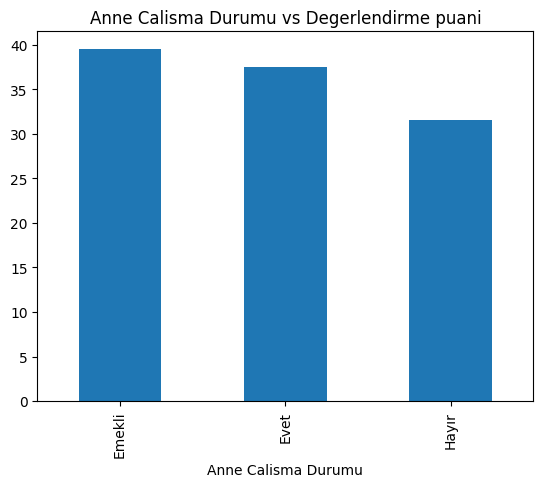

             Anne Sektor  Ratio
Anne Sektor                    
0                  11780 18.088
-                   5827  8.947
Özel Sektör         4425  6.795
Kamu                3805  5.843
ÖZEL SEKTÖR         1617  2.483
KAMU                1344  2.064
Diğer               1333  2.047
DİĞER                457  0.702


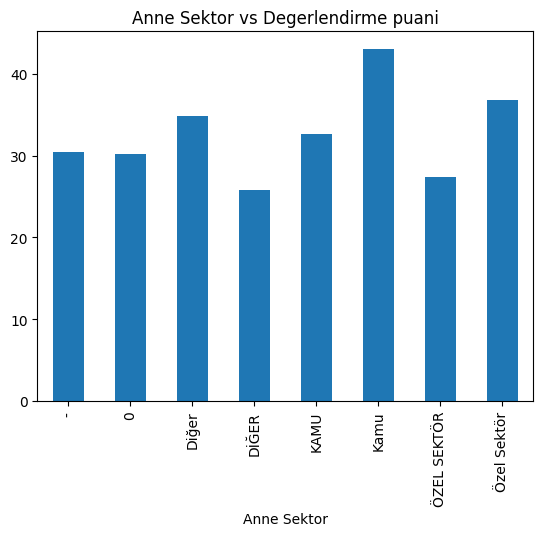

                     Baba Calisma Durumu  Ratio
Baba Calisma Durumu                            
Evet                               28559 43.853
Hayır                              12486 19.172
Emekli                             11462 17.600


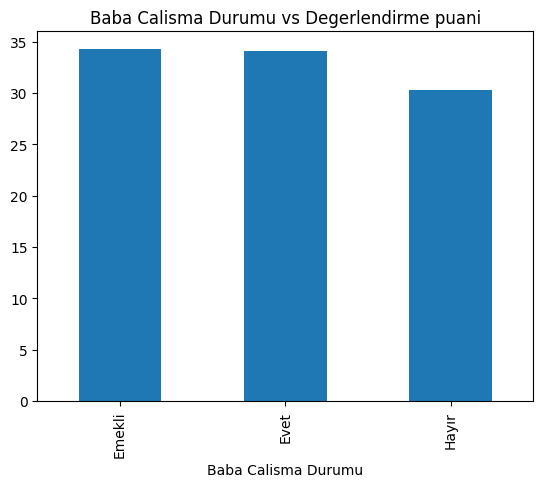

             Baba Sektor  Ratio
Baba Sektor                    
Özel Sektör        11293 17.340
Kamu                7457 11.450
Diğer               6717 10.314
0                   6631 10.182
ÖZEL SEKTÖR         4320  6.633
-                   3070  4.714
KAMU                2862  4.395
DİĞER               2397  3.681


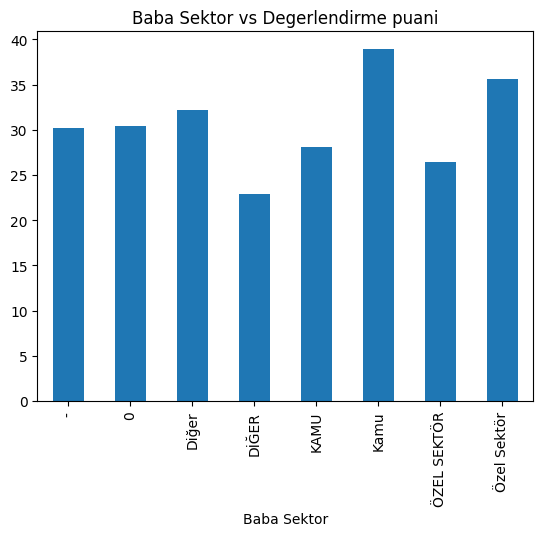

                                                    Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?  Ratio
Girisimcilik Kulupleri Tarzi Bir Kulube Uye mis...                                                             
Hayır                                                                                           33710    51.762
Evet                                                                                            29586    45.430


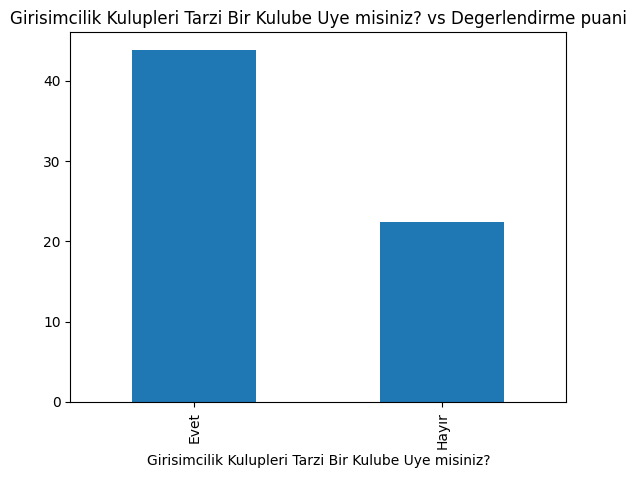

                                              Profesyonel Bir Spor Daliyla Mesgul musunuz?  Ratio
Profesyonel Bir Spor Daliyla Mesgul musunuz?                                                     
Hayır                                                                                42243 64.864
Evet                                                                                 21767 33.423


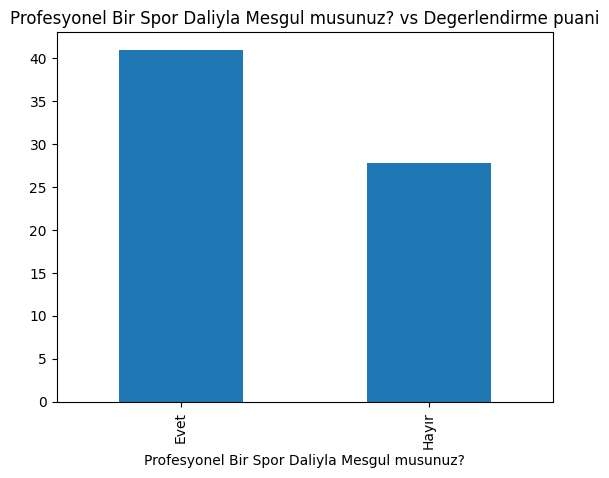

                               Spor Dalindaki Rolunuz Nedir?  Ratio
Spor Dalindaki Rolunuz Nedir?                                      
0                                                      11315 17.374
Diğer                                                   8836 13.568
-                                                       4173  6.408
Lider/Kaptan                                            1994  3.062
DİĞER                                                   1945  2.987
Bireysel                                                1697  2.606
Takım Oyuncusu                                          1175  1.804
Kaptan                                                   873  1.340
KAPTAN / LİDER                                           842  1.293


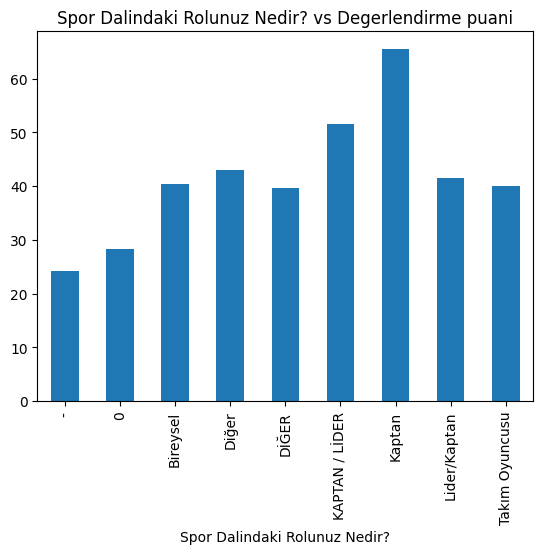

                                     Aktif olarak bir STK üyesi misiniz?  Ratio
Aktif olarak bir STK üyesi misiniz?                                            
Hayır                                                              37716 57.913
Evet                                                               14567 22.368


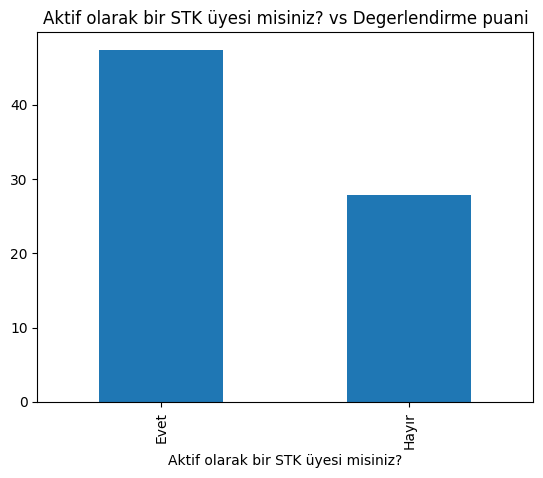

                              Stk Projesine Katildiniz Mi?  Ratio
Stk Projesine Katildiniz Mi?                                     
Hayır                                                19661 30.190
Evet                                                 17156 26.343


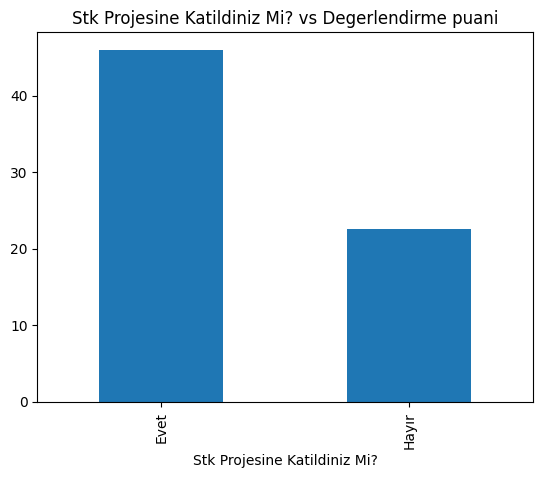

                                           Girisimcilikle Ilgili Deneyiminiz Var Mi?  Ratio
Girisimcilikle Ilgili Deneyiminiz Var Mi?                                                  
Hayır                                                                          33919 52.083
Evet                                                                           18366 28.201


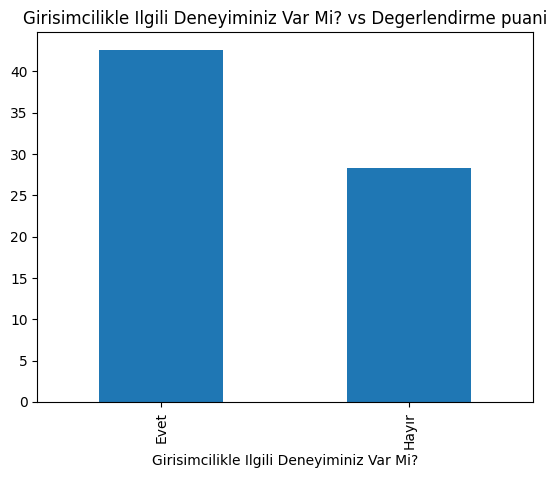

                            Ingilizce Biliyor musunuz?  Ratio
Ingilizce Biliyor musunuz?                                   
Evet                                             48872 75.043
Hayır                                             9799 15.046


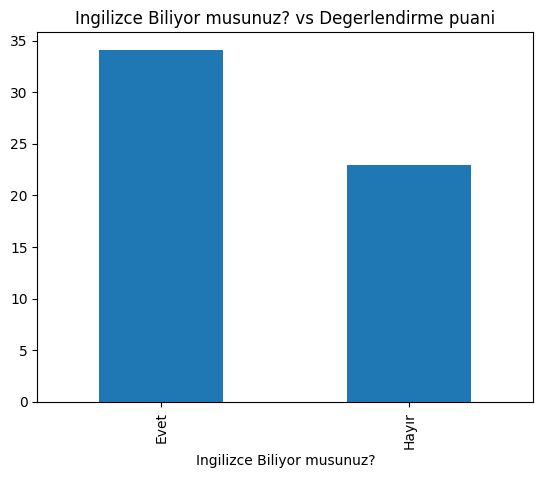

                      Ingilizce Seviyeniz?  Ratio
Ingilizce Seviyeniz?                             
Orta                                 13057 20.049
İleri                                 8318 12.772
Başlangıç                             5180  7.954
0                                     2037  3.128


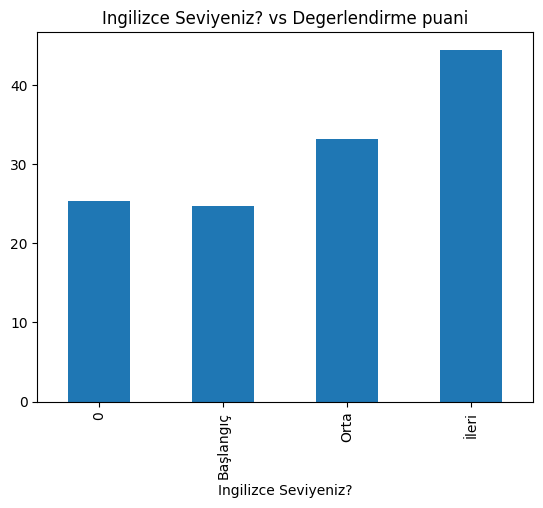

In [12]:
for feature in cat_cols_eda:
        cat_summary(df_train, feature)
        df_train.groupby(feature)['Degerlendirme Puani'].mean().plot.bar()
        plt.title(feature + ' vs Degerlendirme puani')
        plt.show()

count   65125.000
mean     2018.277
std         2.670
min      2014.000
5%       2014.000
10%      2015.000
20%      2015.000
30%      2017.000
40%      2017.000
50%      2019.000
60%      2020.000
70%      2020.000
80%      2021.000
90%      2022.000
95%      2022.000
99%      2022.000
max      2022.000
Name: Basvuru Yili, dtype: float64


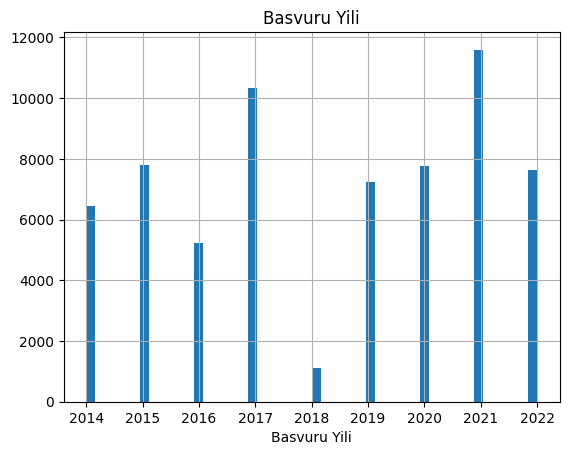

#####################################
count   65124.000
mean       32.086
std        18.139
min         0.000
5%          7.000
10%        10.000
20%        15.000
30%        20.000
40%        24.000
50%        29.000
60%        34.000
70%        40.000
80%        48.000
90%        58.000
95%        66.000
99%        78.000
max       102.000
Name: Degerlendirme Puani, dtype: float64


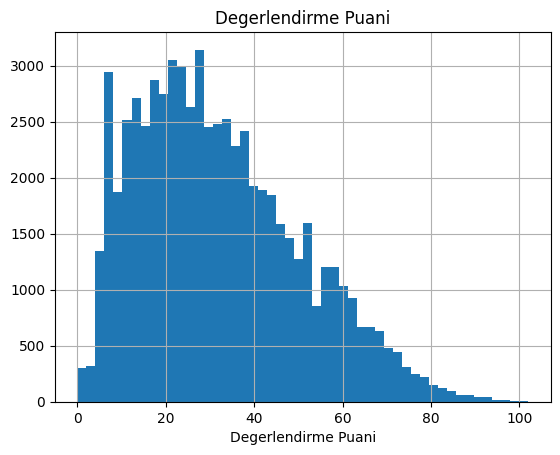

#####################################
count   22440.000
mean       34.226
std        41.632
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%        50.000
70%        50.000
80%       100.000
90%       100.000
95%       100.000
99%       100.000
max       100.000
Name: Burslu ise Burs Yuzdesi, dtype: float64


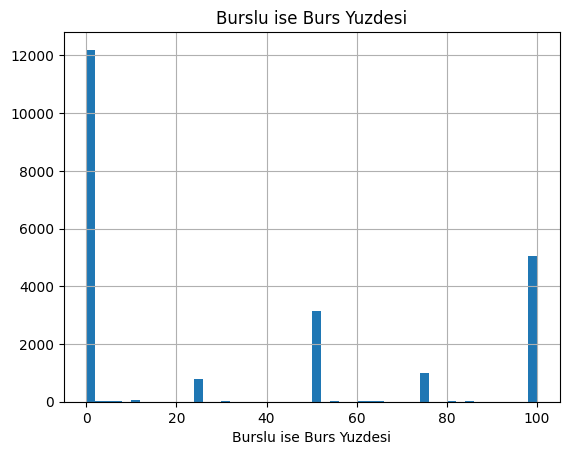

#####################################
count   65125.000
mean    32562.000
std     18800.112
min         0.000
5%       3256.200
10%      6512.400
20%     13024.800
30%     19537.200
40%     26049.600
50%     32562.000
60%     39074.400
70%     45586.800
80%     52099.200
90%     58611.600
95%     61867.800
99%     64472.760
max     65124.000
Name: id, dtype: float64


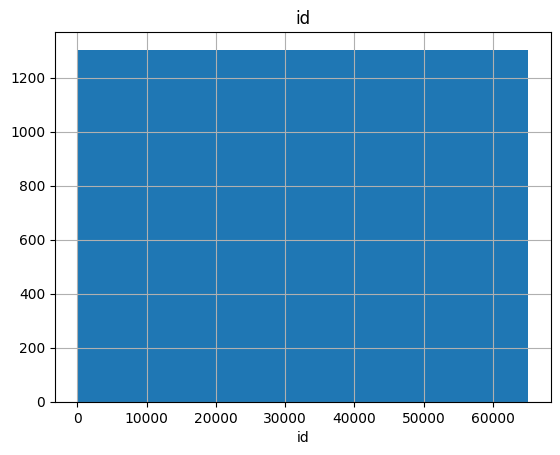

#####################################


In [13]:
for col in num_cols_eda:
    num_summary(df_train, col, True)